<a href="https://colab.research.google.com/github/andersknudby/Remote-Sensing/blob/master/Chapter_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Visualization of data
A really useful thing to be able to do in Python is to visualize your results, so you don't always need to export data to files and open them in QGIS to assess what you have done. In this chapter we will look at how to visualize both raster and vector data, and also how to create some simple plots with such data.

##Getting started
To start with we'll get the image, points, and polygons that we've worked with in previous chapters. Nothing new here, just getting the data ready to work with, except for one thing: We're importing the function **pyplot** from the library **matplotlib**.

In [ ]:
!pip install rasterio
!pip install geopandas
!pip install rasterstats

import rasterio
import geopandas as gpd
import rasterstats

import numpy as np
from shapely.geometry import Point
from matplotlib import pyplot as plt


from google.colab import drive
drive.mount('/content/drive')

myDir = '/content/drive/My Drive/Python files/'

import os
if os.path.exists(myDir + 'sfu.tif'):
  print("Drive mounted and directory found")
else:
  print("No access to the files")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted and directory found


##Plotting raster data
Now read the image. Remember that **band 1 is the 'red band**, and then green, then blue:

In [ ]:
imageFilename = myDir + 'sfu.tif'
ds = rasterio.open(imageFilename)  # ds is a commonly used shorthand for 'dataset'

red = ds.read(1).astype('uint16')
green = ds.read(2).astype('uint16')
blue = ds.read(3).astype('uint16')

We can use the pyplot function to easily show a single band:

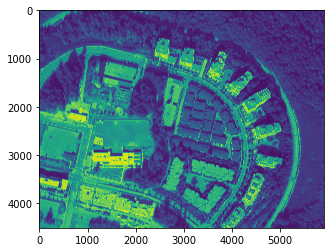

In [ ]:
pyplot.imshow(red)


The colours are a bit weird in the above image, which uses the default matplotlib colormap. They're not bad, just remember that we plotted the red band here, so **bright** pixels are actually those that reflect a lot of red light. When plotting a single band I normally prefer to use a greyscale instead, to avoid any indication that we're looking at multispectral data:

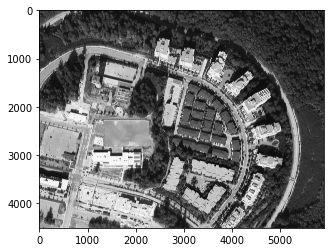

In [ ]:
pyplot.imshow(red, cmap="Greys_r")

However, this is actually a 3-band image, so for visual interpretation we might as well plot all three bands in a true-colour composite. For this purpose rasterio has a special function that we'll import and use to produce an image that looks quite nice actually:

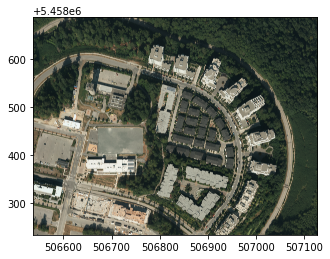

In [ ]:
from rasterio.plot import show
show(ds)

##Plotting points data
On to plotting vector files. We'll start with reading the **points data**:

In [ ]:
pointsFilename = myDir + "points.shp"
pts = gpd.read_file(pointsFilename)
pts

,LandCover,Altitude,geometry
0,Forest,287,POINT (506722.856 5458623.040)
1,Forest,275,POINT (506902.335 5458647.466)
2,Forest,280,POINT (506706.926 5458652.776)
3,Parking lot,290,POINT (506693.651 5458566.223)
4,Parking lot,290,POINT (506707.988 5458563.037)
5,Parking lot,291,POINT (506728.166 5458552.417)


And to plot them:

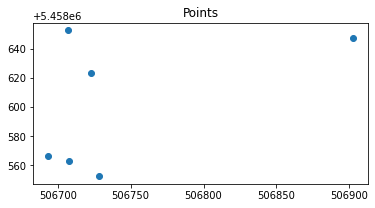

In [ ]:
fig, ax = plt.subplots()
pts.plot(ax=ax)
plt.title("Points")
plt.show()

There are lots of plotting options you can use, e.g. to change the colour, size, and transparency of the points:

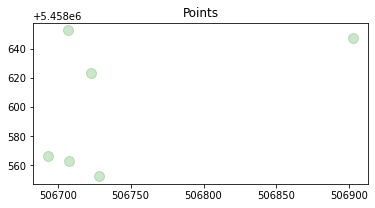

In [ ]:
fig, ax = plt.subplots()
pts.plot(ax=ax, color="green", markersize=100, alpha=0.2)
plt.title("Points")
plt.show()

##Plotting polygon data
It works similarly for the polygons:

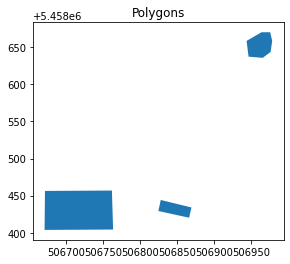

In [ ]:
polygonsFilename = myDir + "polygons.shp"
polys = gpd.read_file(polygonsFilename)  # I often use 'pts' as short for 'points' This is fairly common.
fig, ax = plt.subplots()
polys.plot(ax=ax)
plt.title("Polygons")
plt.show()

Or, to plot the polygons without fill, which is often helpful if you want to see what is inside them (this will be useful later):

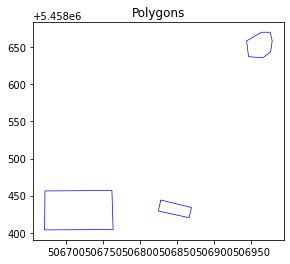

In [ ]:
fig, ax = plt.subplots()
polys.plot(ax=ax, facecolor="none", edgecolor='blue', lw=0.7)
plt.title("Polygons")
plt.show()

Now putting it all together, so we can see where the points and polygons are in relation to the image, and to each other:

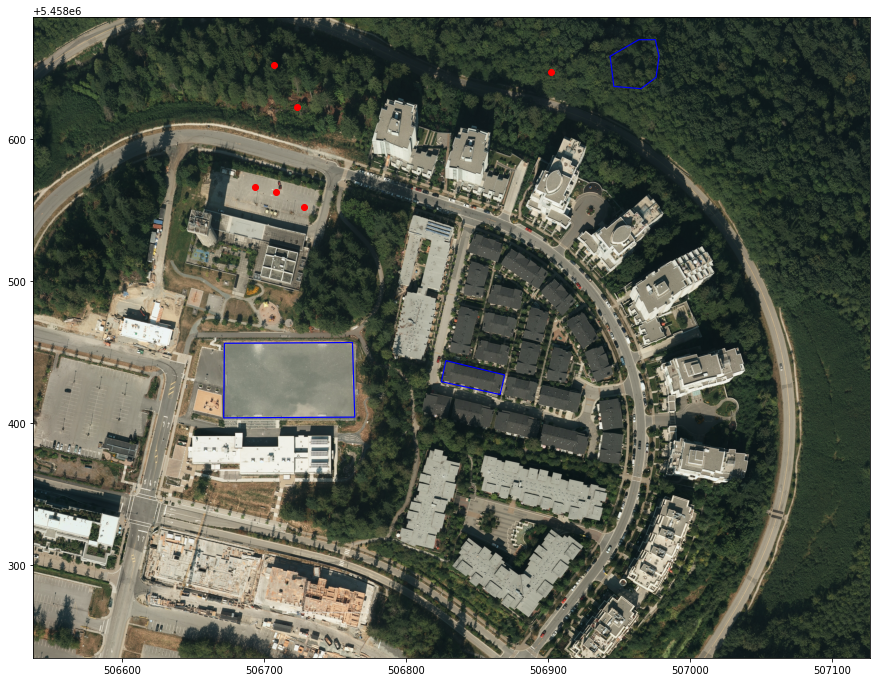

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,15))  # The figsize argument makes the plot a bit bigger, so we can see better
show(ds, ax=ax)  # This puts the image in the plot
pts.plot(ax=ax, color="red")  # ... and the points
polys.plot(ax=ax, facecolor="none", edgecolor='blue', lw=1.2)  # ... and the polygons

##Working with transects
Transects, lines that run across gradients, can be useful to illustrate gradual or abrupt change in the environment. Here we will use a transect to demonstrate how GCC values change across the road that runs along the eastern edge of the image.

First we create the transect and plot it to make sure we put it in the right place:

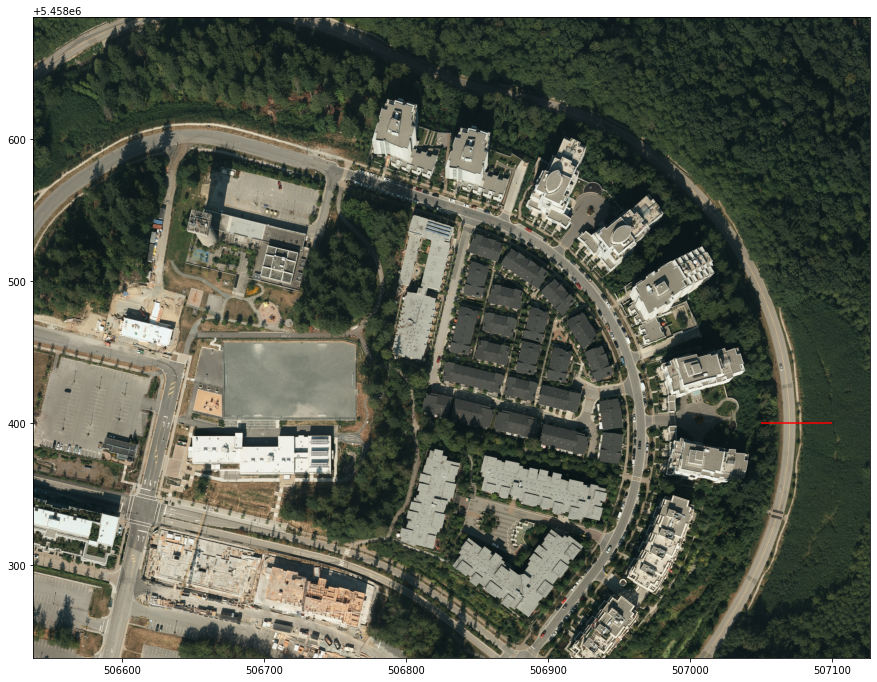

In [ ]:
from shapely.geometry import LineString

transect = LineString([(507050, 5458400), (507100, 5458400)])  # Create the geometry
gdf = gpd.GeoDataFrame(geometry=[transect])  # Turn it into a geodataframe for plotting

# Then plot it with the image
fig, ax = plt.subplots(1, figsize=(15,15))
show(ds, ax=ax)
gdf.plot(ax=ax, color="red")

Ok, now we know the transect is in the right place. But there's no good function to extract values from all pixels under a line, so what we'll do instead is **split the line into points**, and then use the **sample** function from **rasterio** (which is based on points), as we did in the previous chapter:

In [ ]:
from shapely.geometry import MultiPoint
from shapely.ops import split

# The line is 50m long, and the pixels in the image are 10cm across
# So if we want to sample every pixel we need to turn the line into 501 points (point at both ends)
nPoints = 501

# We can use the 'interpolate' function to create a set of evenly spaced points along out transect
multiPoint = MultiPoint([transect.interpolate((i/nPoints), normalized=True) for i in range(nPoints)])

# Before we can use it with the sample function, we need to turn this MultiPoint object into a list of coordinate pairs
pointsAsList = [(p.x, p.y) for p in multiPoint]

# And now we can sample the values from the imagery, in the red, green, and blue bands
redValues = [x[0] for x in ds.sample(pointsAsList, indexes=1)]
greenValues = [x[0] for x in ds.sample(pointsAsList, indexes=2)]
blueValues = [x[0] for x in ds.sample(pointsAsList, indexes=3)]

# To take a quick look and check that there is indeed 501 numbers here:
print(*redValues)

26 26 24 22 23 28 32 28 19 19 18 16 17 17 20 22 17 19 24 24 24 25 25 25 22 18 19 26 28 26 21 20 22 23 23 24 23 22 21 21 22 21 19 20 21 22 23 21 18 16 18 18 18 20 20 15 20 32 56 59 44 30 39 52 51 49 53 68 85 85 63 54 57 57 70 89 102 91 88 101 90 69 79 85 80 61 42 48 58 63 66 61 60 56 45 45 59 58 49 53 54 60 61 50 49 62 63 58 66 76 59 54 57 53 60 63 65 57 57 61 54 49 54 58 61 68 67 72 87 95 97 100 110 105 97 102 95 85 82 77 77 84 96 101 100 102 104 96 91 95 101 98 100 116 122 123 118 118 114 109 120 145 163 165 161 159 162 166 165 166 167 168 166 163 161 162 163 163 163 164 165 164 161 158 161 160 158 160 164 165 165 163 161 161 163 166 167 169 170 171 172 178 207 210 213 206 178 169 168 168 165 165 166 167 165 164 166 167 165 163 162 161 162 161 159 160 161 162 164 163 164 166 168 170 170 170 168 171 174 174 171 170 172 174 172 158 119 87 85 98 94 84 72 66 63 64 68 72 65 46 52 72 66 67 73 68 58 64 73 76 71 63 78 111 145 173 190 198 198 191 191 195 187 174 158 141 130 122 114 94 78 71 72

Ok, now only the plotting is left:

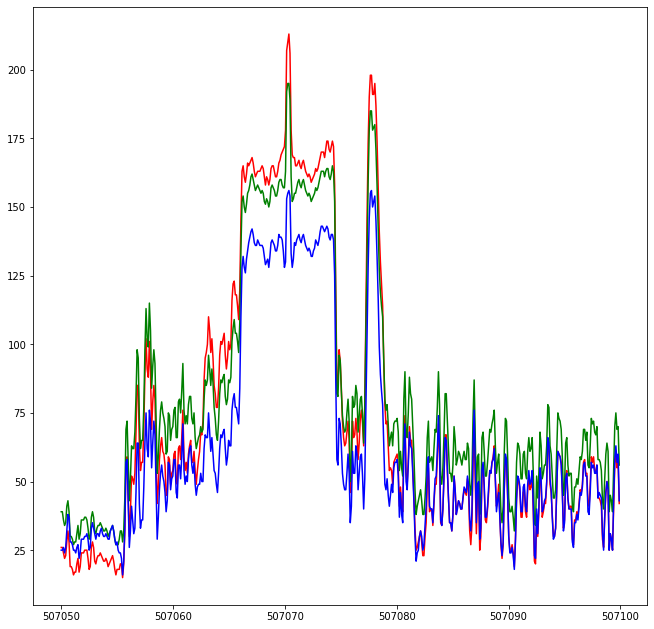

In [ ]:
# To make a nice plot, we need to isolate the x values
xValues = [p.x for p in multiPoint]

# And we'll put it all in a dataframe. This isn't really necessary, but makes plotting easier
data = {'xValues': xValues, 'redValues': redValues, 'greenValues': greenValues, 'blueValues': blueValues} 
df = pd.DataFrame(data) 

fig, ax = plt.subplots(1, figsize=(11,11))
ax.plot(xValues, redValues, color="red")
ax.plot(xValues, greenValues, color="green")
ax.plot(xValues, blueValues, color="blue")

##Exercise
In a new notebook, modify the code in this chapter to plot how the GCC changes across the transect.